In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [98]:
df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')['Close']

[*********************100%***********************]  1 of 1 completed


In [99]:
df.head()

Date
2010-01-04    7.643214
2010-01-05    7.656429
2010-01-06    7.534643
2010-01-07    7.520714
2010-01-08    7.570714
Name: Close, dtype: float64

In [100]:
df.index = pd.to_datetime(df.index)
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).mean())
df.columns=['Value']

In [101]:
df.head()

,Value
Date,
2010-01,7.418402
2010-02,7.099850
2010-03,7.978960
2010-04,8.969592
2010-05,8.980768


<Axes: xlabel='Date'>

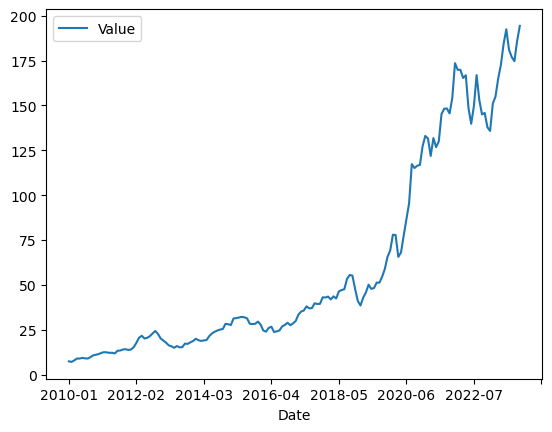

In [102]:
df.plot()

# Making AR and MA model.

In [103]:
#Auto-Regressive model


def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]



#Moving Average Model



def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

<b> Defining a function to check if the Data is stationary

In [104]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

# Implementing ARIMA in 4 steps

Step 1: Differencing the data (I)

Step 2: Fitting the Data through AR model (AR)

Step 3: Fitting the Data through MA mode for residuals (MA)

Step 4: Using model to Generate the Original Data back

STEP 1:

Using Logarithm generate an almost constant variance data. Then using Differencing of 12th term to make the Data even more stationary and remove seasonality

In [105]:
# Apply log transform and differencing
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))

# Perform ADF check on the transformed data to ensure Stationarity
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.769560693080477
p-value : 6.216672874735787e-05
Number of Lags Used : 12
Number of Observations Used : 142
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

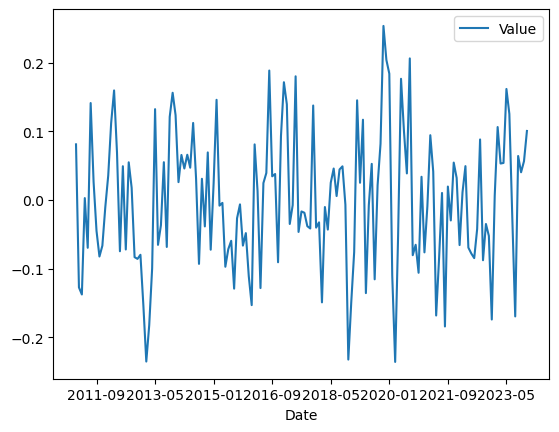

In [106]:
df_testing.plot()

We can find the Value of Parameter P using Auto-correlation and partial auto-correlation plots

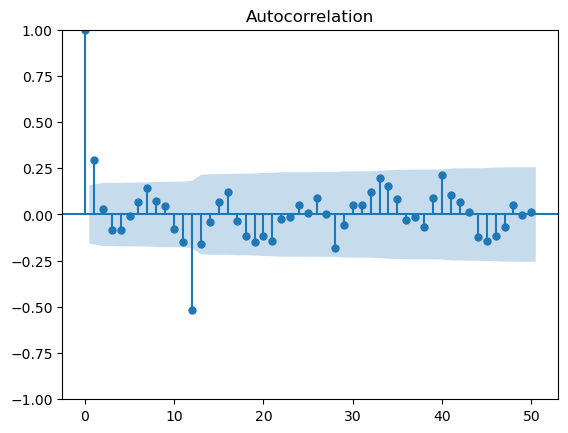

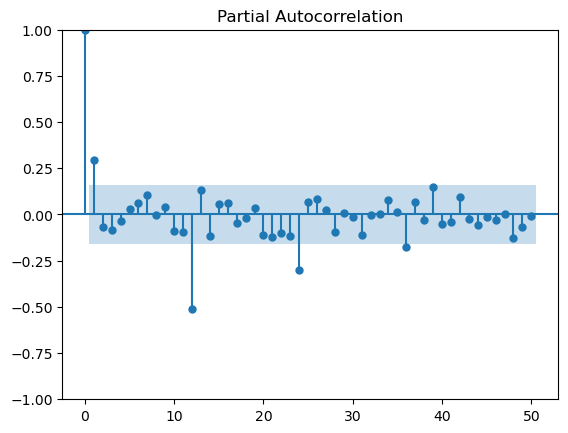

In [107]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

STEP 2: Fitting the AR model

First we need to find the best value of p(order of AR model). Can be done using bruteforce as done below or can be guessed using the Graphs Above

In [108]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.iloc[:, 0]))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.08759558332490688 , Value of p :  1
The RMSE is : 0.08724951410857101 , Value of p :  2
The RMSE is : 0.08999215546657603 , Value of p :  3
The RMSE is : 0.0904061077468771 , Value of p :  4
The RMSE is : 0.09115534350619822 , Value of p :  5
The RMSE is : 0.09042595967635829 , Value of p :  6
The RMSE is : 0.08882871650425658 , Value of p :  7
The RMSE is : 0.0900711851444619 , Value of p :  8
The RMSE is : 0.09194395262340332 , Value of p :  9
The RMSE is : 0.0943269523908008 , Value of p :  10
The RMSE is : 0.09847811759770277 , Value of p :  11
The RMSE is : 0.07585318854173216 , Value of p :  12
The RMSE is : 0.07451511345605176 , Value of p :  13
The RMSE is : 0.07429731014728083 , Value of p :  14
The RMSE is : 0.07380229804835096 , Value of p :  15
The RMSE is : 0.07498050965815488 , Value of p :  16
The RMSE is : 0.0757961374004056 , Value of p :  17
The RMSE is : 0.07819369790520672 , Value of p :  18
The RMSE is : 0.082667167970373 , Value of p :  19
The RMSE

In [109]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.07380229804835096 , Value of p :  15


<Axes: xlabel='Date'>

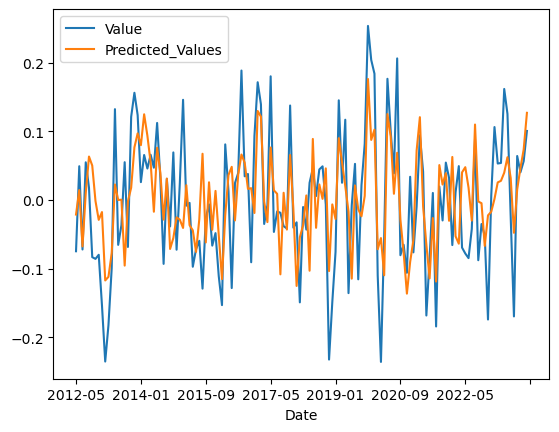

In [110]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

Now, for moving Average portion we need the Residuals or errors of the predictions above. We have already considered this will making the AR model function. res is the residual dataframe.

In [111]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

<Axes: ylabel='Density'>

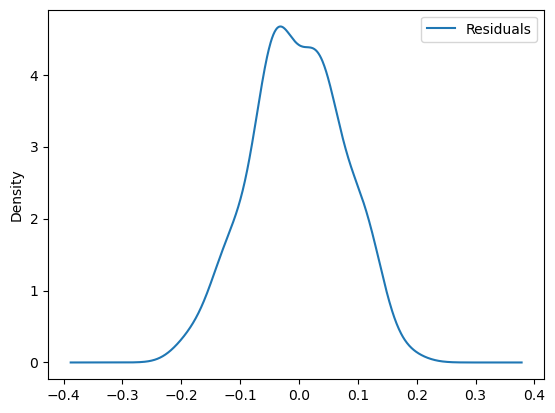

In [112]:
res.plot(kind='kde')

STEP 3:

Here comes the Second part of the model that is Fitting the Moving average model for Residuals.

The RMSE is : 0.07687789130477993 , Value of q :  1
The RMSE is : 0.07696105866615395 , Value of q :  2
The RMSE is : 0.07682073421128231 , Value of q :  3
The RMSE is : 0.07609103967709507 , Value of q :  4
The RMSE is : 0.07616146293126844 , Value of q :  5
The RMSE is : 0.07605999558645 , Value of q :  6
The RMSE is : 0.0763642547430619 , Value of q :  7
The RMSE is : 0.07729496131959711 , Value of q :  8
The RMSE is : 0.07771306743116983 , Value of q :  9
The RMSE is : 0.07740711246373465 , Value of q :  10
The RMSE is : 0.07846701412824371 , Value of q :  11
The RMSE is : 0.07952026405450571 , Value of q :  12
The RMSE is : 0.07818890081546283 , Value of q :  13
The RMSE is : 0.07873227588087389 , Value of q :  14
The RMSE is : 0.07974451561744773 , Value of q :  15
The RMSE is : 0.07867736531814648 , Value of q :  16
The RMSE is : 0.08263659118114604 , Value of q :  17
The RMSE is : 0.08175690291619209 , Value of q :  18
The RMSE is : 0.08788079060801234 , Value of q :  19
6


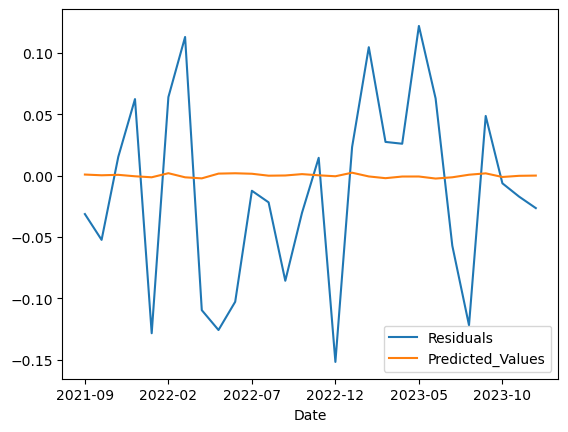

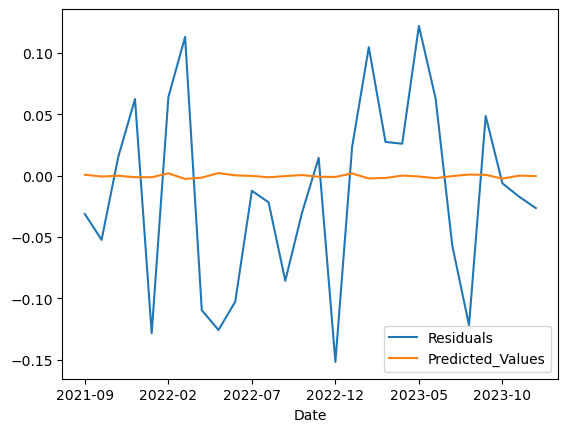

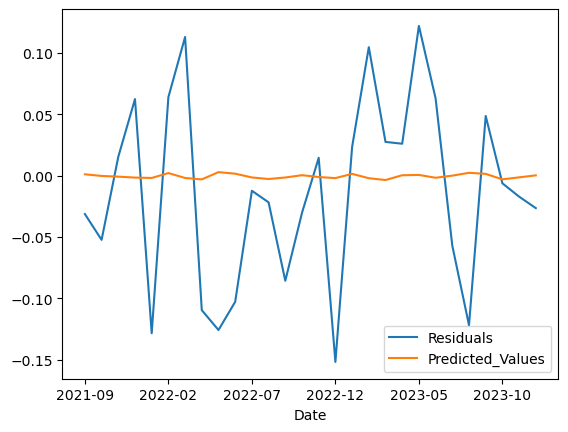

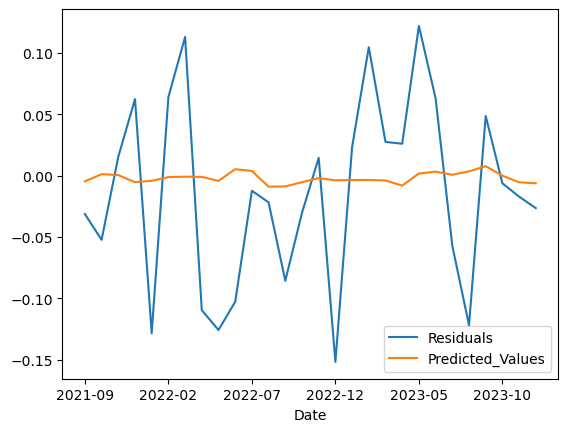

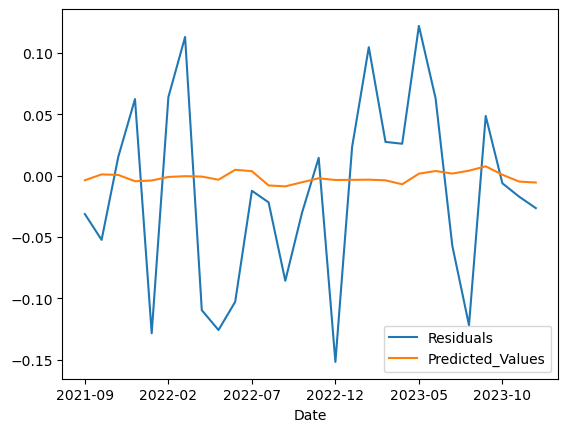

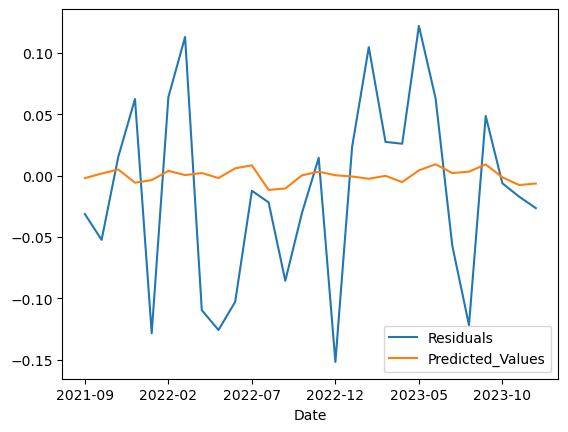

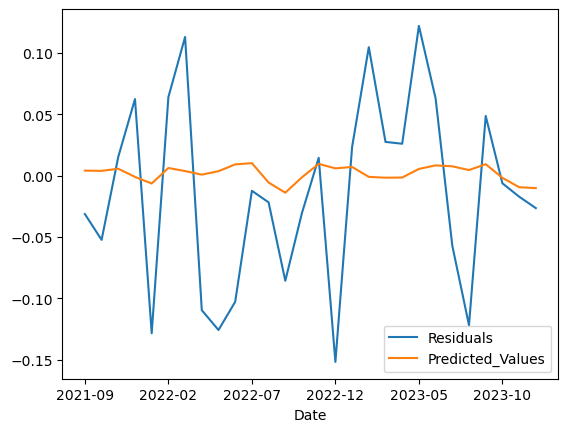

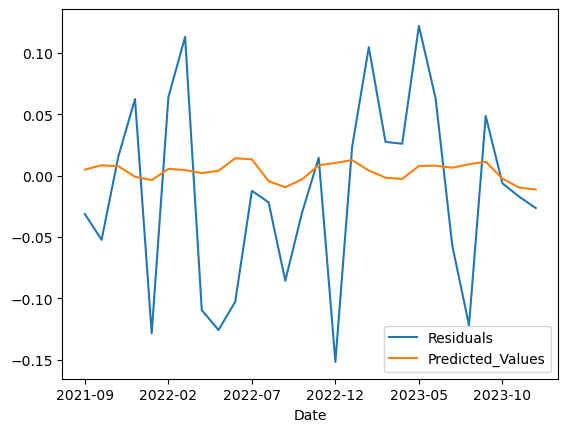

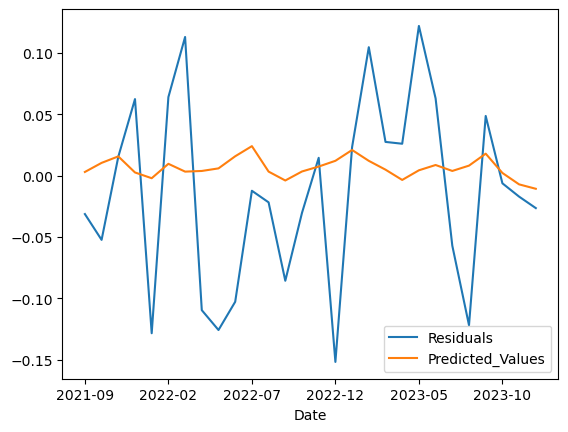

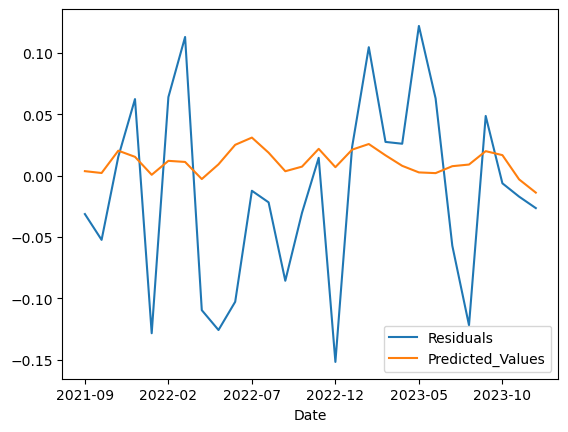

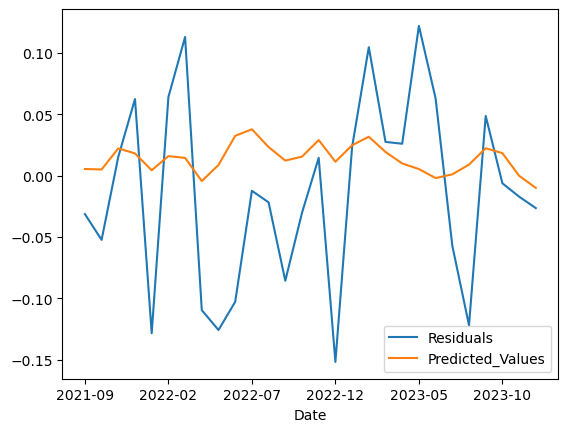

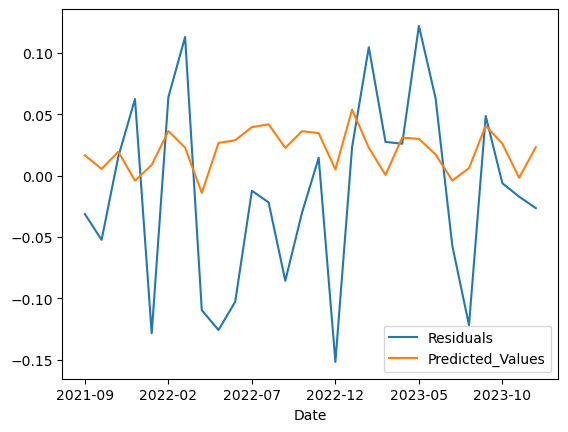

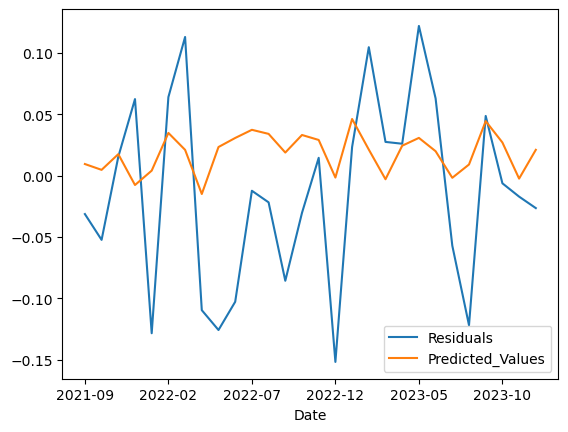

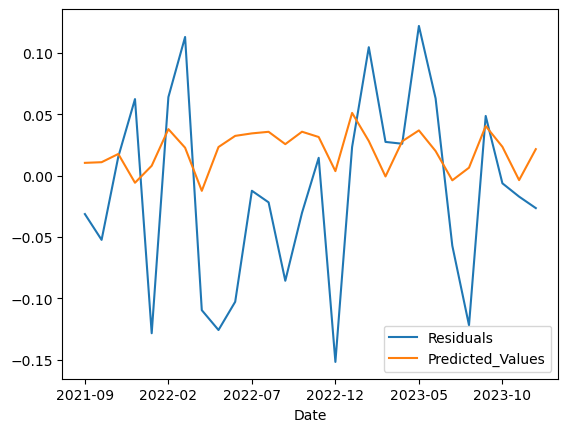

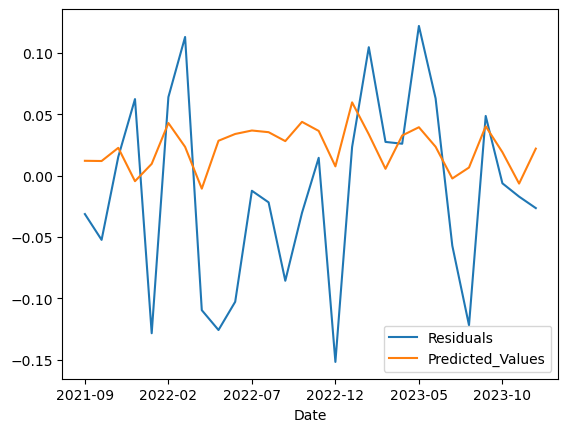

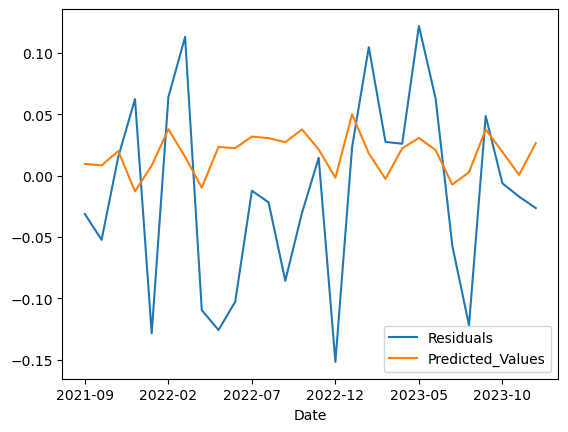

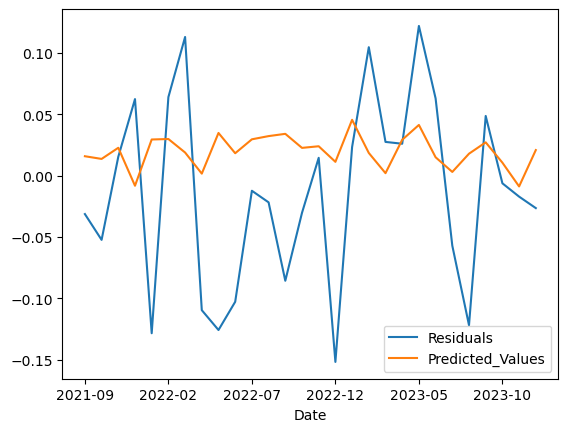

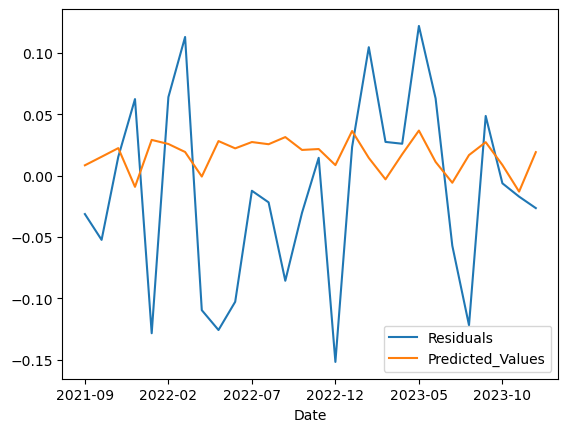

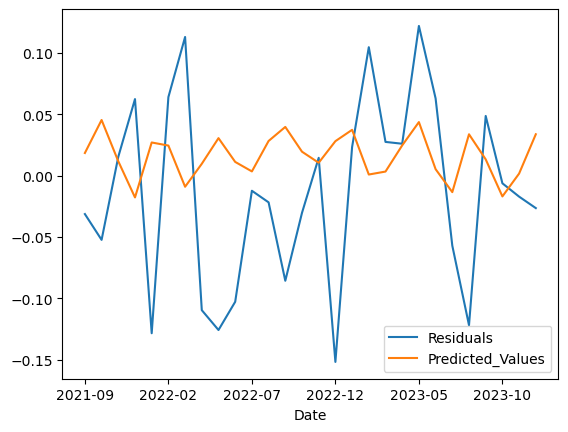

In [113]:
best_RMSE=100000000000
best_q = -1

for i in range(1,20):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The process of Fitting can be seen thorugh the Graphs above.

Considering the best value of q for MA model.

The RMSE is : 0.07605999558645 , Value of q :  6
[[-0.02044636]
 [ 0.01675299]
 [ 0.0175797 ]
 [ 0.05523975]
 [-0.00624955]
 [-0.02962119]]
[0.00074575]


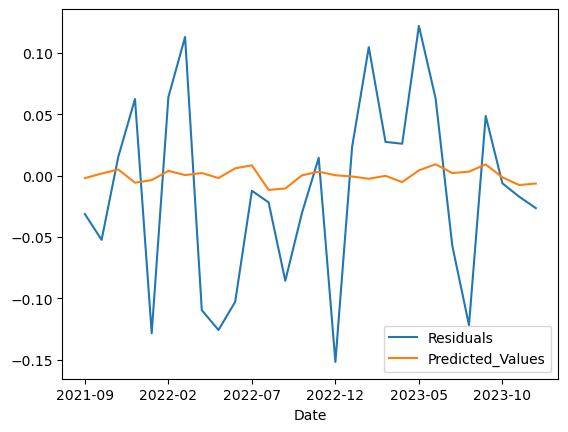

In [114]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [115]:
res_c = pd.concat([res_train,res_test])

In [116]:
df_c.Predicted_Values += res_c.Predicted_Values

<Axes: xlabel='Date'>

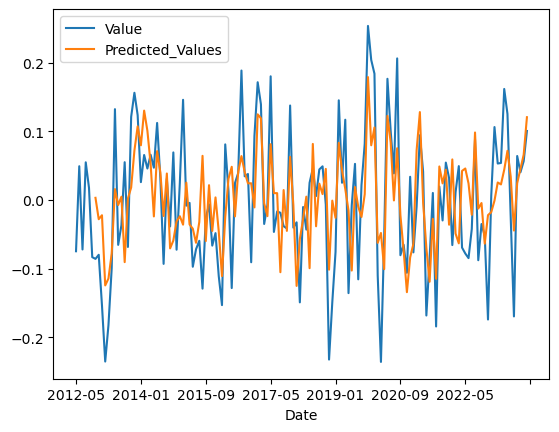

In [117]:
df_c[['Value','Predicted_Values']].plot()

STEP 4: Getting the Original Data by removing Transformations

In [118]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

Our final Plot with predictions is..

<Axes: xlabel='Date'>

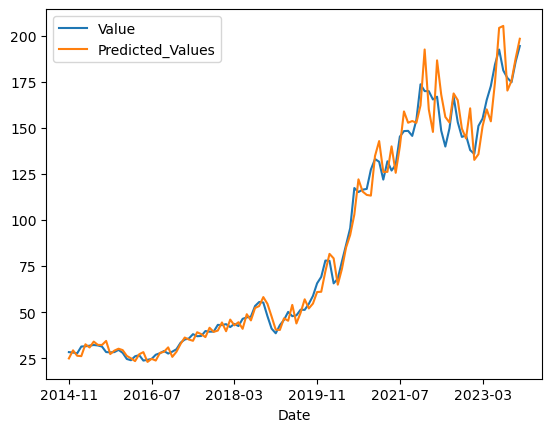

In [119]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()

The plot after around 2020 is the forecasted plot by ARIMA Model